In [1]:

##import libraries
from tinyimagenet import TinyImageNet
from pathlib import Path
import torch
from torchvision import models
import pandas as pd
import os
import torch.utils.data as data
#from torchvision.models._api import WeightsEnum
#from torch.hub import load_state_dict_from_url
import numpy as np
import tmeasures as tm
### para mostrar la trasnformacion
from tinyimagenet import TinyImageNet
from torchvision import transforms as T
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt

import seaborn as sns
from pylab import *
import sys

sns.set()
#%%

#sys.path.append('./Notebooks/')

In [2]:
# load transformations
import transformaciones as tr

rotation_transforms = tr.rotation_transforms()
translation_transforms = tr.translation_transforms()
scale_transforms = tr.scale_transforms()
perspective_transforms = tr.perspective_transforms()
brightness_transforms = [tr.brightness_transforms(factor) for factor in tr.brightness_parameters]
contrast_transformations = [tr.contrast_transforms(alpha) for alpha in tr.contrast_list]
grayscale_transformations = [tr.grayscale_transforms(alpha) for alpha in tr.grey_list]
solarize_transformations = [tr.solarize_transforms(threshold) for threshold in tr.solarization_thresholds]
posterize_transformations = [tr.posterize_transforms(alpha) for alpha in tr.posterize_list]
invertion_transformations = [tr.invertion_transforms(alpha) for alpha in tr.invertion_list]


transformation_afin = [rotation_transforms,
                       translation_transforms,
                       scale_transforms,
                       perspective_transforms,
                       brightness_transforms,
                       contrast_transformations,
                       grayscale_transformations,
                       solarize_transformations,
                       posterize_transformations,
                       invertion_transformations]


transformaciones = ['rotacion','traslacion','escala','proyeccion','brillo','contraste','escala_grises','solarizacion','posterizacion','inversion_colores']

print('import transformations')
transformaciones = transformaciones

import transformations


In [3]:
main_directory = os.path.join('Invariance_Results', 'efficientNet_B0','from_scratch')
print(main_directory)

Invariance_Results/efficientNet_B0/from_scratch


# Calcula la invarianza

In [ ]:
class TinyImageNet(TinyImageNet):
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        return x

normalize_transform = T.Compose(
    [
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(TinyImageNet.mean,TinyImageNet.std),
    #random_ts
    ])


dataset_nolabels = TinyImageNet(root="~/.datasets/tinyimagenet/",split="train", transform=normalize_transform)

# Subsample 
N = 1000
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
indices, _ = train_test_split(np.arange(len(dataset_nolabels)), train_size=N, stratify=dataset_nolabels.targets,random_state=24)
test_inv = Subset(dataset_nolabels, indices)

print(len(test_inv))

In [ ]:
#%%
# Definir el modelo y checkpoint
weights = None #models.EfficientNet_B0_Weights.IMAGENET1K_V1
base_model = models.efficientnet_b0(weights=weights)

for param in base_model.parameters():
    param.requires_grad = True

tinyimagenet_classes = 200

base_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),
    torch.nn.Linear(1280, tinyimagenet_classes),
)

model = torch.nn.Sequential(
   #T.Normalize(TinyImageNet.mean,TinyImageNet.std),
    #weights.transforms(),
    base_model,
)

#%%
main_directory = '/home/tbadaracco/models/efficientnet_b0/weights_none'
print(main_directory)
#main_directory = os.path.join(main_directory, 'AWS','v2')
#print(main_directory)

In [ ]:
# Recorrer las carpetas
for root, dirs, files in os.walk(main_directory):
    # Si el directorio .ipynb_checkpoints está en la lista de directorios, elimínalo
    if '.ipynb_checkpoints' in dirs:
        dirs.remove('.ipynb_checkpoints')
    print(root)
    # Verificar si hay un archivo 'checkpoint_last.ckpt' en la lista de archivos de la carpeta actual
    for dir in dirs:
        dir_path = os.path.join(root, dir)
        model_path = os.path.join(dir_path, 'checkpoint_last.ckpt')
        print("Model Path:", model_path)

        # Definir el folder de resultados para cada combinación de modelo e imagen
        results_folder_original = os.path.join(root, 'Invariance_Results')

        # obtain transformation from directory
        directorio_padre = os.path.dirname(model_path)
        nombre_directorio = os.path.basename(directorio_padre)

        print("Transformacion con la que se entreno: ",nombre_directorio)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(device)
        #results_path = Path("~/tm_example_pytorch/").expanduser()
        #results_path.mkdir(parents=True, exist_ok=True)


        # Load the model state dictionary
        checkpoint = torch.load(model_path, map_location=device)


        # If the checkpoint is a state dictionary directly, use it; otherwise, look for the 'state_dict' key
        if 'state_dict' in checkpoint:
            model_state_dict = checkpoint['state_dict']
        else:
            model_state_dict = checkpoint

        # Load the model state dictionary
        model.load_state_dict(model_state_dict)

        model = model.to(device)
        model.eval()


        results_folder = os.path.join('Invariance_Results/efficientNet_B0/from_scratch/' , nombre_directorio)
        
        image_path = os.path.join(results_folder,'imagenes')
        print("Directorio donde se guardan las medidas de invarianza para ", nombre_directorio,": ",results_folder)
        

        # Verificar si el directorio existee
        if not os.path.exists(image_path):
            # Si no existe, crearlo
            os.makedirs(image_path)
            print(f"Se ha creado el directorio '{image_path}'.")

        for transformacion,transf_vector in zip(transformaciones,transformation_afin):
            print("Transformacion con la que se va evaluar: ",transformacion)
            transformations = [  transf_vector[i] for i in range(len(transf_vector))]
            
            ## results path
            #results_folder = 'Resultados de medida de invarianza'
            csv_path = os.path.join(results_folder, transformacion + '.csv')
            
            # Verificar si el archivo CSV ya existe
            if os.path.exists(csv_path):
                print(f"El archivo CSV '{csv_path}' ya existe. Se pasará al siguiente proceso.")
                continue  # Pasa al siguiente proceso sin guardar el archivo CSV


            # Create an ActivationsModule from the vanilla model
            def filter_stochastic(a):
                return not str(a).startswith("StochasticDepth")

            activations_module = tm.pytorch.AutoActivationsModule(model,filter=filter_stochastic)


            # Define options for computing the measure
            options = tm.pytorch.PyTorchMeasureOptions(batch_size=2, num_workers=0,model_device=device,measure_device=device,data_device = 'cpu') #,data_device="cpu"

            # Define the measure and evaluate it
            measure = tm.pytorch.NormalizedVarianceInvariance()

            print('Se definio la medida')

            measure_result:tm.pytorch.PyTorchMeasureResult = measure.eval(test_inv,transformations,activations_module,options)  ## lista de invarianzas de cada capa

            measure_result = measure_result.numpy()
        

            vec_inv = tm.pytorch.PyTorchMeasureResult.per_layer_average(measure_result)

            vec_layer = measure_result.layer_names

            df_act = pd.DataFrame({'layer_name' : vec_layer,'inv_avg':vec_inv})

            df_act.to_csv(csv_path,index= False)
            print(f'Se guardo el csv en {csv_path}')


In [ ]:
def clean_df(df):

    df['layer_name'] = df['layer_name'].str.replace('/EfficientNet_0/features/','')
    df['layer_name'] = df['layer_name'].str.replace('/EfficientNet_0/','')

    sep='/'
    s=df.layer_name.str.count(sep)
    df_layer_split=((s.max()-s).map(lambda x : x*sep)+df.layer_name).str.split(sep,expand=True)

    df_layer_split.loc[df_layer_split[4] == 'Normalize_0',0] = 'Normalization'

    df_layer_split.loc[(df_layer_split[3] == 'Conv2dNormActivation_0') & (df_layer_split[0] == ''),0] = 'Sequential_0'
    df_layer_split.loc[(df_layer_split[3] == 'Conv2dNormActivation_8') & (df_layer_split[0] == ''),0] = 'Sequential_8'
    df_layer_split.loc[df_layer_split[3] == 'classifier',0] = 'Sequential_8'
    df_layer_split.loc[(df_layer_split[4] == 'avgpool') & (df_layer_split[0] == ''),0] = 'Sequential_8'
    df_layer_split.loc[(df_layer_split[3]== '') & (df_layer_split[0] == 'Sequential_8'),3] = 'pre-classifier'

    #print(df_layer_split.shape)
    df_layer_split = df_layer_split.loc[df_layer_split[0] != ''] 
    #print(df_layer_split.shape)


    cat_layer_order = CategoricalDtype(
        ['Normalize_0','Conv2d_0', 'BatchNorm2d_1', 'SiLU_2', 'avgpool', 'fc1','activation', 'fc2', 'scale_activation', 'Dropout_0', 'Linear_1'],
    ordered=True
    )

    cat_layer_order_2 = CategoricalDtype(
        ['Normalization', 'Conv2dNormActivation_0', 'Conv2dNormActivation_1', 'SqueezeExcitation_1', 'SqueezeExcitation_2', 'Conv2dNormActivation_2', 'Conv2dNormActivation_3', 'Conv2dNormActivation_8', 'pre-classifier', 'classifier'],
        ordered=True
    )

    # Convertir columnas al tipo categórico
    df_layer_split[4] = df_layer_split[4].astype(cat_layer_order)
    df_layer_split[3] = df_layer_split[3].astype(cat_layer_order_2)
    
    df_layer_split.sort_values(by = [0,1,2,3,4], inplace = True)

    df_layer_split.rename(columns={0:'Sequential'},inplace=True)

    df_join = pd.concat([df.loc[:,['layer_name', 'inv_avg']], df_layer_split], axis=1)


    df_join.sort_values(by = ['Sequential',1,2,3,4], inplace = True)
    df_join.reset_index(inplace=True,drop=True)

    df_join['layer'] = df_join[4].str.split('_').str[0]
    df_join['layer'] = df_join['layer'] + '_' + df_join.index.astype(str)
    df_join = df_join.loc[~df_join.Sequential.isna()]
    df_join.reset_index(inplace=True,drop=True)
    #print(df_join.shape)
    
    return df_join



In [ ]:
main_directory = '/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch'
for root, dirs, files in os.walk(main_directory):
    for file in files:
        if file.endswith(".csv") and 'clean' not in file:
            file_path = os.path.join(root, file)
            print(file_path)
            # Leer el archivo CSV
            df = pd.read_csv(file_path)
            #print(df.head())
            # Limpiar el DataFrame
            df_clean = clean_df(df)
            # Obtener el nombre del archivo sin la extensión
            file_name, file_ext = os.path.splitext(file)
            # Construir el nuevo nombre de archivo con "_clean" añadido antes de la extensión
            new_file_name = f"{file_name}_clean{file_ext}"
            # Construir la ruta de destino para guardar el archivo CSV limpio
            csv_path = os.path.join(root, new_file_name)
            # Guardar el DataFrame limpio como un nuevo archivo CSV
            df_clean.to_csv(csv_path, index=False)
            print(f'Se guardó el archivo CSV limpio en {csv_path}')
            #aplico el primer grafico


In [ ]:
def grafico_completo(df_join,entrenado_transformacion,transformacion):
    
    #cmap = plt.cm.get_cmap('plasma', 9)    # PiYG
    cmap = plt.colormaps['plasma'].resampled(9)
    color = []
    for i in range(cmap.N):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba

        color.append(matplotlib.colors.rgb2hex(rgba))

    df_join = df_join.iloc[1:,:]
    df_join.reset_index(inplace = True,drop=True)
    keys = df_join['Sequential'].unique()
    colours =  dict(zip(keys, color))


    plt.figure(figsize=(35,8))
    for i in range(len(df_join)-1):
        x = df_join['layer'][i], df_join['layer'][i+1]
        y = df_join['inv_avg'][i], df_join['inv_avg'][i+1]
        c = colours[df_join['Sequential'][i]]
        ax = sns.lineplot(x=x, y=y,color = c,linewidth = 5)
        mod_layer = df_join['layer'].str.split('_').str[0]
        ax.set(xlim=(0, 15))
        ax.set_xticks(range(len(df_join)), labels=mod_layer)
        ax.tick_params(axis='x', rotation=90 ,which='major', pad=15)
        ax.set_xlabel("Capas")
        ax.set_ylabel("Varianza Normalizada")
        ax.set_title(f'Invarianza por capa EfficientNetB0 re-entrenado con {entrenado_transformacion} y evaluado en {transformacion}')

    # Obtener la figura actual y guardarla en una variable
    fig = plt.gcf()
    return fig


In [ ]:
main_directory = '/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch'
print(main_directory)
## Aplico primer gráfico
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        
        # Recorrer los archivos dentro de cada carpeta
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(sub_root, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)

                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)

                    # Verificar si el gráfico ya ha sido guardado
                    imagenes_dir = os.path.join(sub_root, 'imagenes')
                    imagen_path = os.path.join(imagenes_dir, f'{file_name}_plot_1.png')
                    if os.path.exists(imagen_path):
                        print("El gráfico ya existe, paso al siguiente")
                        continue

                    # Crear gráfico
                    fig = grafico_completo(df, nombre_directorio, file_name)
                    fig.savefig(imagen_path)
                    print(f'Se guardó el gráfico en {imagen_path}')

In [ ]:
cmap = plt.colormaps['plasma'].resampled(9)    # PiYG
color = []
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    color.append(matplotlib.colors.rgb2hex(rgba))

In [ ]:
def grafico_por_estados(df_join,entrenado_transformacion,transformacion):
    
    df_join = df_join.iloc[1:,:]
    df_join.reset_index(inplace = True,drop=True)
    keys = df_join['Sequential'].unique()
    colours =  dict(zip(keys, color))
    #  Categorical Data
    a = 3  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize=(20,8))

    for seq in df_join.Sequential.unique():
        plt.subplot(a, b, c)
        df = df_join.loc[df_join.Sequential == seq,]
        col = colours[seq]
        g = sns.lineplot(data = df, x='layer', y='inv_avg',color = col,linewidth = 2,marker = 'o')
        mod_layer = df['layer'].str.split('_').str[0]
        #g.set(xlim=(0, 15))
        g.set_xticks(range(len(df)), labels=mod_layer)
        g.tick_params(axis='x', rotation=90 )
        c = c + 1
        plt.xticks(df['layer'][::1])
        g.set_xlabel("Capas")
        g.set_ylabel("Varianza Normalizada")
        titulo = 'Estado ' + str(c - 1)
        plt.title(titulo)
        titulo_general = f'Invarianza por capa con transformación re-entrenado con {entrenado_transformacion} y evaluado en {transformacion}'
        plt.suptitle(titulo_general, fontsize=16)
        plt.tight_layout()

    fig = plt.gcf()
    return fig

In [ ]:
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        #print(dir_path)
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                #print(file)
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(dir_path, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)
                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)
                    # Verificar si el gráfico ya ha sido guardado
                    imagenes_dir = os.path.join(dir_path,'imagenes')
                    imagen_path = os.path.join(imagenes_dir, f'{file_name}_plot_2.png')
                    if os.path.exists(imagen_path):
                        print("el grafico ya existe paso al sgte")
                        continue
                        # Saltar este archivo si ya ha sido procesado
                    #creo grafico
                    fig = grafico_por_estados(df,nombre_directorio,file_name)
                    fig.savefig(imagen_path)
                    print(f'Se guardó el gráfico en {imagen_path}')

In [ ]:
#  quito los bloques SE para analizar la varianza sin esos bloques xq no son secuenciales
bloque_se = ['avgpool',
'fc1',
'activation',
'fc2',
'scale_activation']

In [ ]:
def grafico_sinbloqueSE_completo(df_join,entrenado_transformacion,transformacion):
    df1 = df_join.loc[~(df_join['4'].isin(bloque_se))]
    df2 = df_join.loc[(df_join['4'].isin(bloque_se)) & (df_join.Sequential == 'Sequential_8')]
    df = pd.concat([df1,df2],axis = 0)
    df = df.loc[df.Sequential != 'Normalization',]
    df.reset_index(inplace=True,drop=True)
    print(df.shape)

    keys = df['Sequential'].unique()
    colours =  dict(zip(keys, color))


    plt.figure(figsize=(35,8))
    for i in range(len(df)-1):
        x = df['layer'][i], df['layer'][i+1]
        y = df['inv_avg'][i], df['inv_avg'][i+1]
        c = colours[df['Sequential'][i]]
        ax = sns.lineplot(x=x, y=y,color = c,linewidth = 5,marker = 'o')
        mod_layer = df['layer'].str.split('_').str[0]
        ax.set(xlim=(0, 15))
        ax.set_xticks(range(len(df)), labels=mod_layer)
        ax.tick_params(axis='x', rotation=90 ,which='major', pad=15)
        ax.set_xlabel("Capas")
        ax.set_ylabel("Varianza Normalizada")
        ax.set_title(f'Invarianza por capa EfficientNetB0 sin bloques SE y re-entrenado con {entrenado_transformacion} y evaluado en {transformacion}')

    fig = plt.gcf()
    return fig
        #plt.savefig(os.path.join(image_path , 'invarianza sin bloque SE-' + transformacion + '.png'))

In [ ]:
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        
        # Recorrer los archivos dentro de cada carpeta
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                #print(files)
        
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(dir_path, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)
                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)
                    # Verificar si el gráfico ya ha sido guardado
                    imagenes_dir = os.path.join(dir_path,'imagenes')
                    imagen_path = os.path.join(imagenes_dir, f'{file_name}_plot_3.png')
                    if os.path.exists(imagen_path):
                        print("el grafico ya existe paso al sgte")
                        continue
                        # Saltar este archivo si ya ha sido procesado
                    #creo grafico
                    fig = grafico_sinbloqueSE_completo(df,nombre_directorio,file_name)
                    fig.savefig(imagen_path)
                    print(f'Se guardó el gráfico en {imagen_path}')

In [ ]:
def grafico_sinbloqueSE_estado(df_join,entrenado_transformacion,transformacion):
    df1 = df_join.loc[~(df_join['4'].isin(bloque_se))]
    df2 = df_join.loc[(df_join['4'].isin(bloque_se)) & (df_join.Sequential == 'Sequential_8')]
    df = pd.concat([df1,df2],axis = 0)
    df = df.loc[df.Sequential != 'Normalization',]
    df.reset_index(inplace=True,drop=True)
    
    print(df.shape)


    keys = df['Sequential'].unique()
    colours =  dict(zip(keys, color))
        #  Categorical Data
    a = 3  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize=(20,10))

    for seq in df.Sequential.unique():
        plt.subplot(a, b, c)
        df_fil = df.loc[df.Sequential == seq,]
        col = colours[seq]
        g = sns.lineplot(data = df_fil, x='layer', y='inv_avg',color = col,linewidth = 2,marker = 'o')
        mod_layer = df_fil['layer'].str.split('_').str[0]
        #g.set(xlim=(0, 15))
        g.set_xticks(range(len(df_fil)), labels=mod_layer)
        g.tick_params(axis='x', rotation=90 )
        c = c + 1
        plt.xticks(df_fil['layer'][::1])
        g.set_xlabel("Capas")
        g.set_ylabel("Varianza Normalizada")
        titulo = 'Estado ' + str(c - 1)
        plt.title(titulo)
        titulo_general = f'Invarianza por capa EfficienNetB0 sin bloques SE re-entrenado con transformación {entrenado_transformacion} y evaluado con {transformacion}'
        plt.suptitle(titulo_general, fontsize=16)
    
    plt.tight_layout()

    fig = plt.gcf()
    return fig

In [ ]:
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        
        # Recorrer los archivos dentro de cada carpeta
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(dir_path, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)
                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)
                    # Verificar si el gráfico ya ha sido guardado
                    imagenes_dir = os.path.join(dir_path,'imagenes')
                    imagen_path = os.path.join(imagenes_dir, f'{file_name}_plot_4.png')
                    fig = grafico_sinbloqueSE_estado(df,nombre_directorio,file_name)
                    fig.savefig(imagen_path)
                    print(f'Se guardó el gráfico en {imagen_path}')

In [ ]:
def grafico_boxplot(df_join,entrenado_transformacion,transformacion):
    df1 = df_join.loc[~(df_join['4'].isin(bloque_se))]
    df2 = df_join.loc[(df_join['4'].isin(bloque_se)) & (df_join.Sequential == 'Sequential_8')]
    df = pd.concat([df1,df2],axis = 0)
    df = df.loc[df.Sequential != 'Normalization',]
    df.reset_index(inplace=True,drop=True)
    

    plt.figure(figsize=(10, 6))
    ##boxplot
    df['Estado'] = df['Sequential'].replace({
        'Sequential_0': 'Estado 1',
        'Sequential_1': 'Estado 2',
        'Sequential_2': 'Estado 3',
        'Sequential_3': 'Estado 4',
        'Sequential_4': 'Estado 5',
        'Sequential_5': 'Estado 6',
        'Sequential_6': 'Estado 7',
        'Sequential_7': 'Estado 8',
        'Sequential_8': 'Estado 9'
    })

    keys = df['Sequential'].unique()
    colours =  dict(zip(keys, color))
    
    # Crear una paleta de colores personalizada basada en el diccionario de colores
    custom_palette = sns.color_palette([colours[val] for val in df['Sequential'].unique()])

    # Crear un gráfico de caja utilizando seaborn con el parámetro "hue" y sin leyenda
    g = sns.boxplot(data=df, x='inv_avg', y='Estado', palette=custom_palette, dodge=False)

    # Establecer etiquetas de los ejes x e y
    g.set_xlabel("Varianza Normalizada")
    g.set_ylabel("Estado")

    # Establecer el título del gráfico
    titulo = f'Invarianza por capa EfficienNetB0 sin bloques SE re-entrenado con transformación {entrenado_transformacion} y evaluado con {transformacion}'
    plt.title(titulo)

    fig = plt.gcf()
    return fig


In [ ]:
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        
        # Recorrer los archivos dentro de cada carpeta
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(dir_path, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)
                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)
                    # Verificar si el gráfico ya ha sido guardado
                    imagenes_dir = os.path.join(dir_path,'imagenes')
                    imagen_path = os.path.join(imagenes_dir, f'{file_name}_plot_5.png')
                    if os.path.exists(imagen_path):
                        print("el grafico ya existe paso al sgte")
                        continue
                        # Saltar este archivo si ya ha sido procesado
                    fig = grafico_boxplot(df,nombre_directorio,file_name)
                    fig.savefig(imagen_path)
                    print(f'Se guardó el gráfico en {imagen_path}')

# Junto todos los csv para poder sacar metricas de la invarianza

In [ ]:
df_complete = pd.DataFrame()
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        
        # Recorrer los archivos dentro de cada carpeta
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(dir_path, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)
                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)
                    
                    ## agrego columnas entrenado e invarianza
                    df['Training'] = nombre_directorio
                    df['Eval'] = file_name
                    ## concateno
                    df_complete = pd.concat([df_complete,df])

In [ ]:
os.getcwd()

In [ ]:
df_complete.info()

In [ ]:
df_complete.head()

In [ ]:
path = '/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch/df_complete.csv'
df_complete.to_csv(path, index=False)

In [4]:
path = 'Invariance_Results/efficientNet_B0/from_scratch/df_complete.csv'
df_complete = pd.read_csv(path)
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23540 entries, 0 to 23539
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   layer_name  23540 non-null  object 
 1   inv_avg     23540 non-null  float64
 2   Sequential  23540 non-null  object 
 3   1           22550 non-null  object 
 4   2           22550 non-null  object 
 5   3           23540 non-null  object 
 6   4           23540 non-null  object 
 7   layer       23540 non-null  object 
 8   Training    23540 non-null  object 
 9   Eval        23540 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.8+ MB


In [5]:
df_complete.head()

,layer_name,inv_avg,Sequential,1,2,3,4,layer,Training,Eval
0,Conv2dNormActivation_0/Conv2d_0,0.773710,Sequential_0,NaN,NaN,Conv2dNormActivation_0,Conv2d_0,Conv2d_0,proyeccion,escala
1,Conv2dNormActivation_0/BatchNorm2d_1,0.760651,Sequential_0,NaN,NaN,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_1,proyeccion,escala
2,Conv2dNormActivation_0/SiLU_2,0.760651,Sequential_0,NaN,NaN,Conv2dNormActivation_0,SiLU_2,SiLU_2,proyeccion,escala
3,Sequential_1/MBConv_0/block/Conv2dNormActivati...,0.860515,Sequential_1,MBConv_0,block,Conv2dNormActivation_0,Conv2d_0,Conv2d_3,proyeccion,escala
4,Sequential_1/MBConv_0/block/Conv2dNormActivati...,0.860339,Sequential_1,MBConv_0,block,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_4,proyeccion,escala


In [9]:
round(df_complete.inv_avg.min(),2)

0.03

In [12]:
df_complete.Training.value_counts()

Proyeccion           2140
Traslacion           2140
Brillo               2140
Escala               2140
Inversion colores    2140
Escala grises        2140
Rotacion             2140
Solarizacion         2140
Contraste            2140
Identidad            2140
Posterizacion        2140
Name: Training, dtype: int64

In [9]:
df_complete.loc[df_complete.Training == 'without_transformation','Training'] = 'Identidad'

In [11]:
# Función para transformar los valores
def transformar_texto(texto):
    return texto.replace('_', ' ').capitalize()

# Aplicar la transformación a la columna
df_complete['Training'] = df_complete['Training'].apply(transformar_texto)
df_complete['Eval'] = df_complete['Eval'].apply(transformar_texto)


In [14]:
df_complete.Eval.value_counts()

Escala               2354
Inversion colores    2354
Escala grises        2354
Brillo               2354
Proyeccion           2354
Contraste            2354
Solarizacion         2354
Posterizacion        2354
Rotacion             2354
Traslacion           2354
Name: Eval, dtype: int64

In [15]:
df_complete.reset_index(inplace=True,drop=True)
df_complete

,layer_name,inv_avg,Sequential,1,2,3,4,layer,Training,Eval
0,Conv2dNormActivation_0/Conv2d_0,0.773710,Sequential_0,NaN,NaN,Conv2dNormActivation_0,Conv2d_0,Conv2d_0,Proyeccion,Escala
1,Conv2dNormActivation_0/BatchNorm2d_1,0.760651,Sequential_0,NaN,NaN,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_1,Proyeccion,Escala
2,Conv2dNormActivation_0/SiLU_2,0.760651,Sequential_0,NaN,NaN,Conv2dNormActivation_0,SiLU_2,SiLU_2,Proyeccion,Escala
3,Sequential_1/MBConv_0/block/Conv2dNormActivati...,0.860515,Sequential_1,MBConv_0,block,Conv2dNormActivation_0,Conv2d_0,Conv2d_3,Proyeccion,Escala
4,Sequential_1/MBConv_0/block/Conv2dNormActivati...,0.860339,Sequential_1,MBConv_0,block,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_4,Proyeccion,Escala
...,...,...,...,...,...,...,...,...,...,...
23535,Conv2dNormActivation_8/BatchNorm2d_1,0.263663,Sequential_8,NaN,NaN,Conv2dNormActivation_8,BatchNorm2d_1,BatchNorm2d_209,Posterizacion,Traslacion
23536,Conv2dNormActivation_8/SiLU_2,0.263663,Sequential_8,NaN,NaN,Conv2dNormActivation_8,SiLU_2,SiLU_210,Posterizacion,Traslacion
23537,avgpool,0.192932,Sequential_8,NaN,NaN,pre-classifier,avgpool,avgpool_211,Posterizacion,Traslacion
23538,classifier/Dropout_0,0.192932,Sequential_8,NaN,NaN,classifier,Dropout_0,Dropout_212,Posterizacion,Traslacion


In [16]:
df_complete.Training.unique()

array(['Proyeccion', 'Traslacion', 'Brillo', 'Escala',
       'Inversion colores', 'Escala grises', 'Rotacion', 'Solarizacion',
       'Contraste', 'Identidad', 'Posterizacion'], dtype=object)

In [17]:
import re
# Función para extraer el sufijo numérico
def extract_numeric_suffix(layer):
    match = re.search(r'_(\d+)$', layer)
    return int(match.group(1)) if match else -1

# Crear una nueva columna con el sufijo numérico
df_complete['layer_num'] = df_complete['layer'].apply(extract_numeric_suffix)

In [18]:
order_transformation = CategoricalDtype(
    ['Identidad','Brillo', 'Contraste', 'Escala grises','Inversion colores', 'Posterizacion','Solarizacion', 'Escala','Proyeccion', 'Rotacion', 'Traslacion'],
    ordered=True
)

# Convertir columnas al tipo categórico
df_complete['Training'] = df_complete['Training'].astype(order_transformation)
df_complete['Eval'] = df_complete['Eval'].astype(order_transformation)
df_complete.sort_values(by = ['Training','Eval','Sequential', 'layer_num'], ascending=[True, True, True, True],inplace=True)
df_complete

,layer_name,inv_avg,Sequential,1,2,3,4,layer,Training,Eval,layer_num
19902,Conv2dNormActivation_0/Conv2d_0,0.643125,Sequential_0,NaN,NaN,Conv2dNormActivation_0,Conv2d_0,Conv2d_0,Identidad,Brillo,0
19903,Conv2dNormActivation_0/BatchNorm2d_1,0.662298,Sequential_0,NaN,NaN,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_1,Identidad,Brillo,1
19904,Conv2dNormActivation_0/SiLU_2,0.662298,Sequential_0,NaN,NaN,Conv2dNormActivation_0,SiLU_2,SiLU_2,Identidad,Brillo,2
19905,Sequential_1/MBConv_0/block/Conv2dNormActivati...,0.544358,Sequential_1,MBConv_0,block,Conv2dNormActivation_0,Conv2d_0,Conv2d_3,Identidad,Brillo,3
19906,Sequential_1/MBConv_0/block/Conv2dNormActivati...,0.542709,Sequential_1,MBConv_0,block,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_4,Identidad,Brillo,4
...,...,...,...,...,...,...,...,...,...,...,...
4275,Conv2dNormActivation_8/BatchNorm2d_1,0.262432,Sequential_8,NaN,NaN,Conv2dNormActivation_8,BatchNorm2d_1,BatchNorm2d_209,Traslacion,Traslacion,209
4276,Conv2dNormActivation_8/SiLU_2,0.262432,Sequential_8,NaN,NaN,Conv2dNormActivation_8,SiLU_2,SiLU_210,Traslacion,Traslacion,210
4277,avgpool,0.167111,Sequential_8,NaN,NaN,pre-classifier,avgpool,avgpool_211,Traslacion,Traslacion,211
4278,classifier/Dropout_0,0.167111,Sequential_8,NaN,NaN,classifier,Dropout_0,Dropout_212,Traslacion,Traslacion,212


In [19]:
df_complete.loc[df_complete.Sequential == 'Sequential_0']

,layer_name,inv_avg,Sequential,1,2,3,4,layer,Training,Eval,layer_num
19902,Conv2dNormActivation_0/Conv2d_0,0.643125,Sequential_0,NaN,NaN,Conv2dNormActivation_0,Conv2d_0,Conv2d_0,Identidad,Brillo,0
19903,Conv2dNormActivation_0/BatchNorm2d_1,0.662298,Sequential_0,NaN,NaN,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_1,Identidad,Brillo,1
19904,Conv2dNormActivation_0/SiLU_2,0.662298,Sequential_0,NaN,NaN,Conv2dNormActivation_0,SiLU_2,SiLU_2,Identidad,Brillo,2
20330,Conv2dNormActivation_0/Conv2d_0,0.336706,Sequential_0,NaN,NaN,Conv2dNormActivation_0,Conv2d_0,Conv2d_0,Identidad,Contraste,0
20331,Conv2dNormActivation_0/BatchNorm2d_1,0.328400,Sequential_0,NaN,NaN,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_1,Identidad,Contraste,1
...,...,...,...,...,...,...,...,...,...,...,...
3853,Conv2dNormActivation_0/BatchNorm2d_1,0.806762,Sequential_0,NaN,NaN,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_1,Traslacion,Rotacion,1
3854,Conv2dNormActivation_0/SiLU_2,0.806762,Sequential_0,NaN,NaN,Conv2dNormActivation_0,SiLU_2,SiLU_2,Traslacion,Rotacion,2
4066,Conv2dNormActivation_0/Conv2d_0,0.482181,Sequential_0,NaN,NaN,Conv2dNormActivation_0,Conv2d_0,Conv2d_0,Traslacion,Traslacion,0
4067,Conv2dNormActivation_0/BatchNorm2d_1,0.468692,Sequential_0,NaN,NaN,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_1,Traslacion,Traslacion,1


In [20]:
df_complete.groupby(['Training','Eval']).inv_avg.describe()

count      mean       std       min       25%  \
Training   Eval                                                               
Identidad  Brillo             214.0  0.308555  0.116929  0.223368  0.245780   
           Contraste          214.0  0.526404  0.114159  0.328400  0.440888   
           Escala grises      214.0  0.223192  0.060403  0.118382  0.177736   
           Inversion colores  214.0  0.577451  0.062880  0.439391  0.540241   
           Posterizacion      214.0  0.763734  0.287753  0.537680  0.601919   
...                             ...       ...       ...       ...       ...   
Traslacion Solarizacion       214.0  0.867652  0.414906  0.429325  0.656761   
           Escala             214.0  0.784557  0.181738  0.412844  0.625268   
           Proyeccion         214.0  0.719026  0.151726  0.263095  0.640270   
           Rotacion           214.0  0.669858  0.277384  0.126456  0.389382   
           Traslacion         214.0  0.385958  0.245030  0.074365  0.140070   

                                   50%       75%       max  
Training   Eval                                             
Identidad  Brillo             0.266315  0.306591  1.066190  
           Contraste          0.489546  0.585147  0.902709  
           Escala grises      0.224002  0.260575  0.386513  
           Inversion colores  0.577596  0.615801  0.778884  
           Posterizacion      0.654499  0.769904  1.959222  
...                                ...       ...       ...  
Traslacion Solarizacion       0.778022  0.920324  3.351392  
           Escala             0.781031  0.937917  1.244982  
           Proyeccion         0.721628  0.824503  1.030622  
           Rotacion           0.777366  0.914037  1.041168  
           Traslacion         0.315568  0.582438  0.893465  

[110 rows x 8 columns]

In [56]:
# Crear un diccionario de reemplazo
reemplazo = {f'Sequential_{i}': f'Estado {i+1}' for i in range(9)}

# Reemplazar los valores
df_complete['Sequential'] = df_complete['Sequential'].replace(reemplazo)
df_complete

,layer_name,inv_avg,Sequential,1,2,3,4,layer,Training,Eval,layer_num
19902,Conv2dNormActivation_0/Conv2d_0,0.643125,Estado 1,NaN,NaN,Conv2dNormActivation_0,Conv2d_0,Conv2d_0,Identidad,Brillo,0
19903,Conv2dNormActivation_0/BatchNorm2d_1,0.662298,Estado 1,NaN,NaN,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_1,Identidad,Brillo,1
19904,Conv2dNormActivation_0/SiLU_2,0.662298,Estado 1,NaN,NaN,Conv2dNormActivation_0,SiLU_2,SiLU_2,Identidad,Brillo,2
19905,Sequential_1/MBConv_0/block/Conv2dNormActivati...,0.544358,Estado 2,MBConv_0,block,Conv2dNormActivation_0,Conv2d_0,Conv2d_3,Identidad,Brillo,3
19906,Sequential_1/MBConv_0/block/Conv2dNormActivati...,0.542709,Estado 2,MBConv_0,block,Conv2dNormActivation_0,BatchNorm2d_1,BatchNorm2d_4,Identidad,Brillo,4
...,...,...,...,...,...,...,...,...,...,...,...
4275,Conv2dNormActivation_8/BatchNorm2d_1,0.262432,Estado 9,NaN,NaN,Conv2dNormActivation_8,BatchNorm2d_1,BatchNorm2d_209,Traslacion,Traslacion,209
4276,Conv2dNormActivation_8/SiLU_2,0.262432,Estado 9,NaN,NaN,Conv2dNormActivation_8,SiLU_2,SiLU_210,Traslacion,Traslacion,210
4277,avgpool,0.167111,Estado 9,NaN,NaN,pre-classifier,avgpool,avgpool_211,Traslacion,Traslacion,211
4278,classifier/Dropout_0,0.167111,Estado 9,NaN,NaN,classifier,Dropout_0,Dropout_212,Traslacion,Traslacion,212


In [21]:
df_complete.columns

Index(['layer_name', 'inv_avg', 'Sequential', '1', '2', '3', '4', 'layer',
       'Training', 'Eval', 'layer_num'],
      dtype='object')

In [57]:
df_mean = df_complete.groupby(['Training', 'Eval','Sequential']).agg({'inv_avg':'mean'}).reset_index()

In [58]:
df_mean

,Training,Eval,Sequential,inv_avg
0,Identidad,Identidad,Estado 1,NaN
1,Identidad,Identidad,Estado 2,NaN
2,Identidad,Identidad,Estado 3,NaN
3,Identidad,Identidad,Estado 4,NaN
4,Identidad,Identidad,Estado 5,NaN
...,...,...,...,...
1084,Traslacion,Traslacion,Estado 5,0.460338
1085,Traslacion,Traslacion,Estado 6,0.368900
1086,Traslacion,Traslacion,Estado 7,0.250704
1087,Traslacion,Traslacion,Estado 8,0.220646


In [59]:
df_mean.shape

(1089, 4)

In [60]:
df_mean = df_mean.loc[df_mean.Eval != 'Identidad']

In [61]:
df_pivot = df_mean.pivot(index=['Training', 'Sequential'], columns=["Eval"], values="inv_avg")
df_pivot

Eval                     Brillo  Contraste  Escala grises  Inversion colores  \
Training   Sequential                                                          
Identidad  Estado 1    0.655907   0.331168       0.158520           0.533155   
           Estado 2    0.588165   0.483730       0.236920           0.620188   
           Estado 3    0.394999   0.561510       0.206479           0.634616   
           Estado 4    0.323662   0.535718       0.199656           0.612055   
           Estado 5    0.282117   0.529891       0.215230           0.568479   
...                         ...        ...            ...                ...   
Traslacion Estado 5    0.318399   0.484127       0.224164           0.546158   
           Estado 6    0.276164   0.485237       0.222018           0.513252   
           Estado 7    0.258034   0.505189       0.282156           0.538530   
           Estado 8    0.269121   0.531690       0.309135           0.545526   
           Estado 9    0.354330   0.574115       0.360700           0.610367   

Eval                   Posterizacion  Solarizacion    Escala  Proyeccion  \
Training   Sequential                                                      
Identidad  Estado 1         0.758126      0.529796  0.760140    0.700789   
           Estado 2         1.200810      0.970450  0.682097    0.545978   
           Estado 3         0.847639      0.847965  0.775688    0.701549   
           Estado 4         0.918284      1.068186  0.858439    0.780875   
           Estado 5         0.798692      1.030411  0.896460    0.803049   
...                              ...           ...       ...         ...   
Traslacion Estado 5         0.787243      0.893325  0.929409    0.767183   
           Estado 6         0.670869      0.818195  0.806144    0.727362   
           Estado 7         0.674967      0.869184  0.648051    0.662121   
           Estado 8         0.703090      0.873743  0.634770    0.661380   
           Estado 9         0.745574      0.925969  0.668852    0.705178   

Eval                   Rotacion  Traslacion  
Training   Sequential                        
Identidad  Estado 1    0.817618    0.457046  
           Estado 2    0.500467    0.386979  
           Estado 3    0.637860    0.550988  
           Estado 4    0.721384    0.581299  
           Estado 5    0.791208    0.559889  
...                         ...         ...  
Traslacion Estado 5    0.733877    0.460338  
           Estado 6    0.719341    0.368900  
           Estado 7    0.599499    0.250704  
           Estado 8    0.572843    0.220646  
           Estado 9    0.578121    0.229705  

[99 rows x 10 columns]

In [43]:
df_pivot.columns

CategoricalIndex(['Brillo', 'Contraste', 'Escala grises', 'Inversion colores',
                  'Posterizacion', 'Solarizacion', 'Escala', 'Proyeccion',
                  'Rotacion', 'Traslacion'],
                 categories=['Identidad', 'Brillo', 'Contraste', 'Escala grises', ..., 'Escala', 'Proyeccion', 'Rotacion', 'Traslacion'], ordered=True, dtype='category', name='Eval')

In [30]:
#df_pivot.drop(columns = 'Identidad',inplace=True)

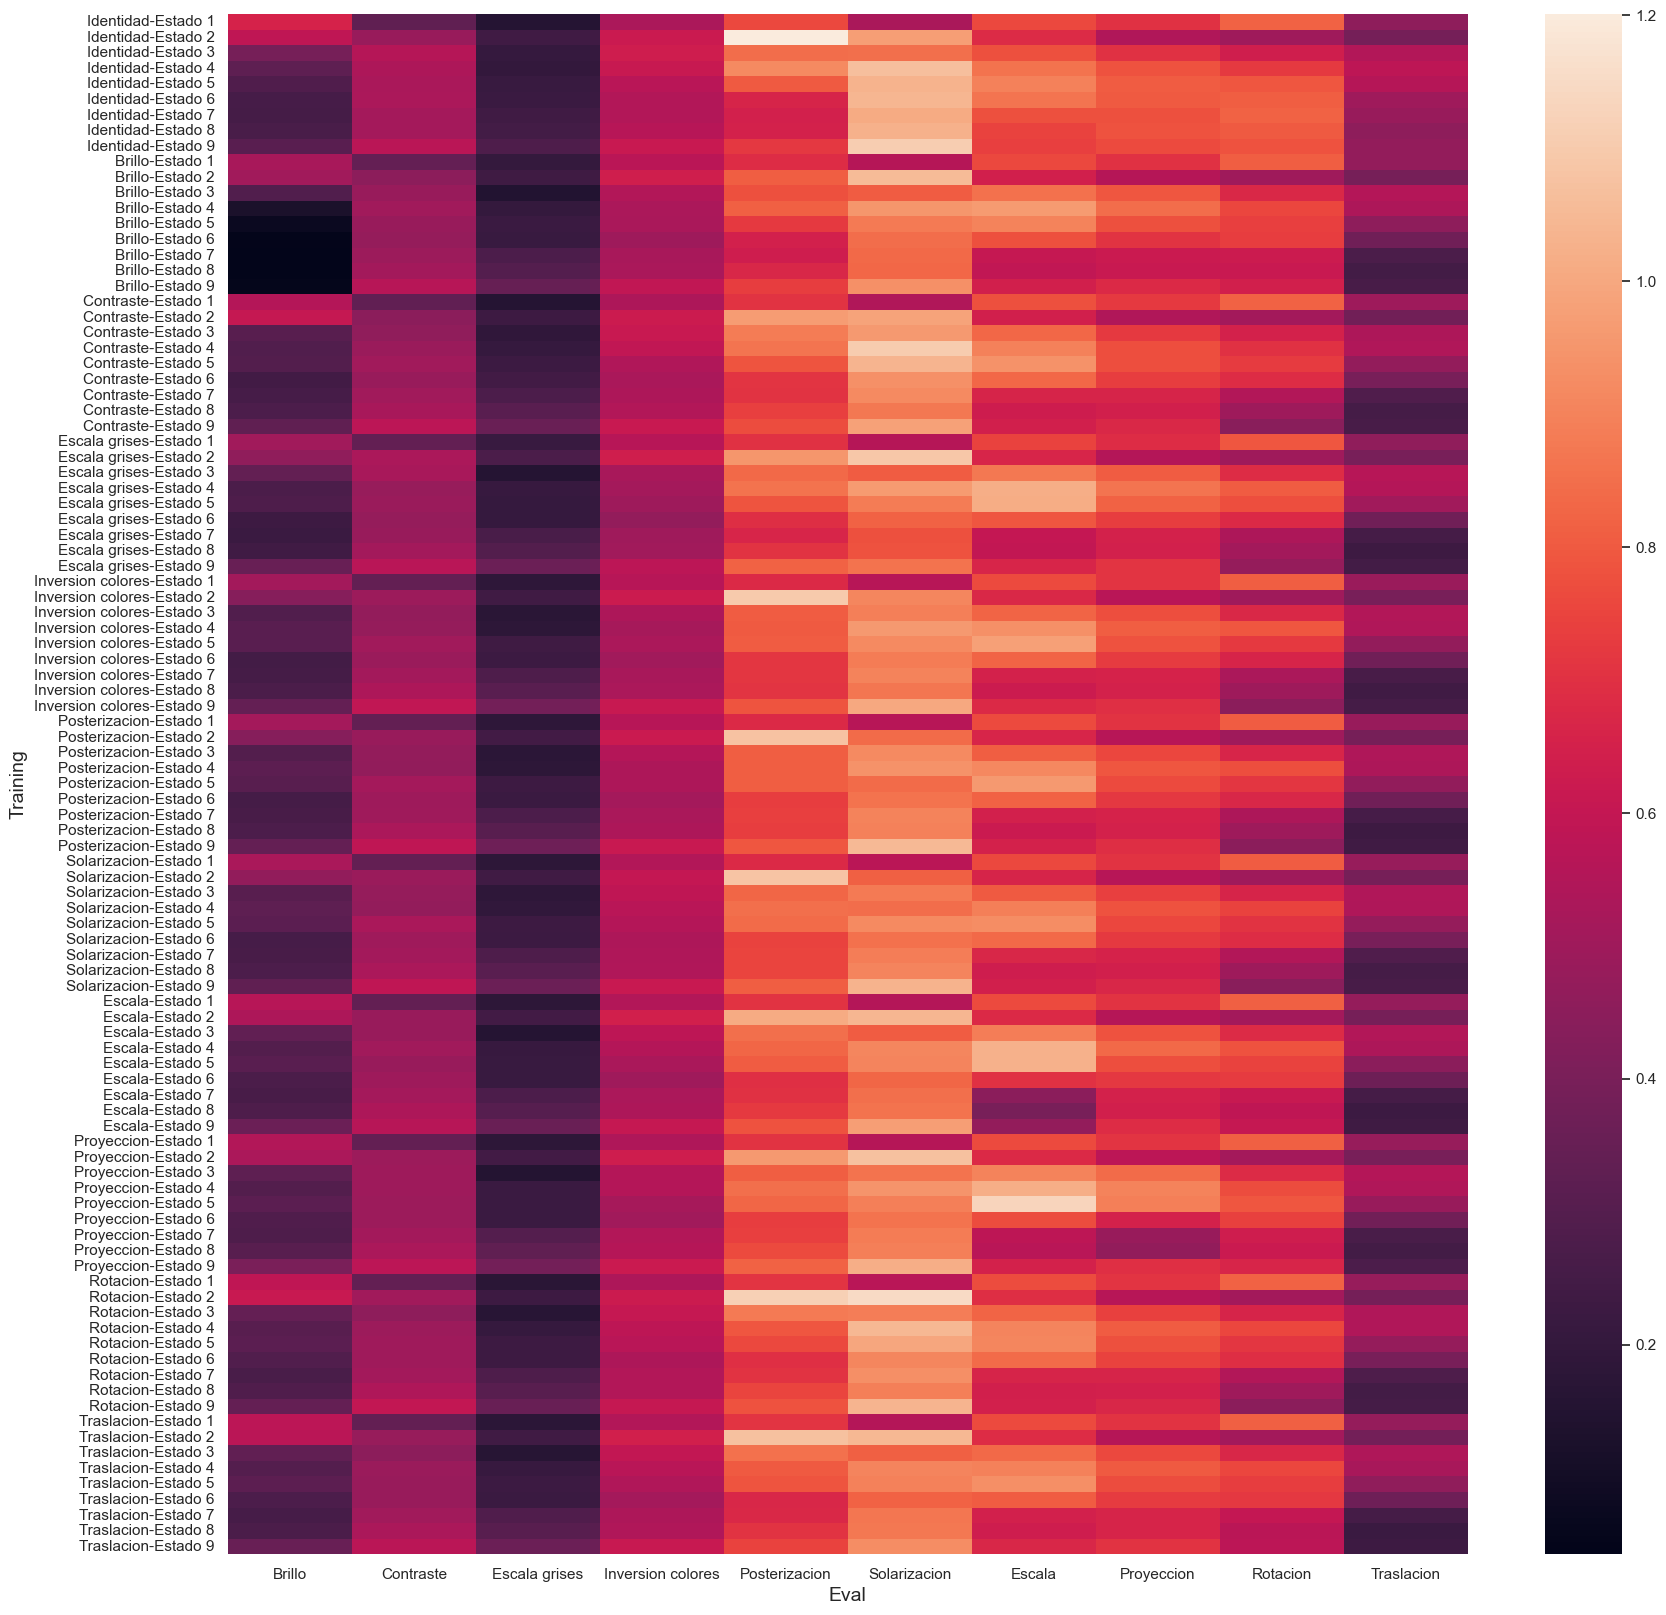

In [48]:
# Crear el mapa de colores
plt.figure(figsize=(20, 20))
sns.heatmap(df_pivot, annot=False, cbar=True)
plt.xlabel('Eval', fontsize=14)
plt.ylabel('Training', fontsize=14)
#plt.title('Heatmap de promedio de Invarianza por Estado')
plt.savefig('fromscratch_heatmap_promedio_invarianza_estado.png', dpi=300, bbox_inches='tight')  # Alta calidad para impresión

plt.show()

In [49]:
df_pivot2 = df_mean.pivot_table(index=['Training'], columns='Eval', values='inv_avg', aggfunc='mean')
df_pivot2

Eval,Brillo,Contraste,Escala grises,Inversion colores,Posterizacion,Solarizacion,Escala,Proyeccion,Rotacion,Traslacion
Training,,,,,,,,,,
Identidad,0.370119,0.508792,0.223030,0.583050,0.799975,0.958925,0.788283,0.739584,0.742425,0.494101
Brillo,0.189689,0.479301,0.238454,0.551943,0.721804,0.855221,0.748281,0.699063,0.676791,0.396425
Contraste,0.351471,0.481254,0.243107,0.571914,0.790794,0.926266,0.761138,0.694076,0.620636,0.403362
Escala grises,0.321633,0.489653,0.244046,0.533126,0.778965,0.837673,0.774026,0.718659,0.639885,0.398738
Inversion colores,0.330387,0.490632,0.245614,0.550776,0.789726,0.877126,0.773126,0.707508,0.626189,0.397155
Posterizacion,0.332975,0.487928,0.243622,0.556089,0.796783,0.867945,0.760476,0.699534,0.622717,0.391037
Solarizacion,0.339806,0.492813,0.245046,0.566867,0.815113,0.855984,0.757546,0.692689,0.621456,0.403906
Escala,0.357465,0.490145,0.240698,0.559977,0.788942,0.858815,0.710408,0.706485,0.674201,0.387321
Proyeccion,0.365289,0.492351,0.250244,0.560500,0.799694,0.886028,0.784911,0.690641,0.693149,0.403738


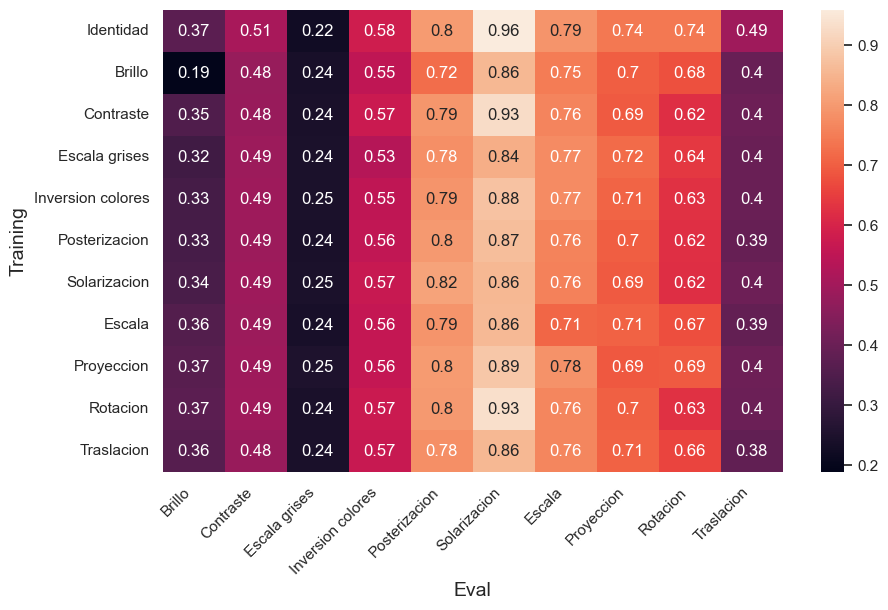

In [51]:

# Crear el mapa de colores
plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot2, annot=True, cbar=True)

#plt.title('Heatmap de promedio de Invarianza por Estado')
plt.xlabel('Eval', fontsize=14)
plt.ylabel('Training', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas en el eje X
plt.yticks(rotation=0)  # Mantener etiquetas del eje Y horizontales

#plt.title('Heatmap de promedio de Invarianza por Estado')
plt.savefig('fromscratch_heatmap_promedio_de_los_promedios_invarianza_por_estado.png', dpi=300, bbox_inches='tight')  # Alta calidad para impresión

plt.show()

In [ ]:
os.getcwd()

### Mismo analisis sin bloque SE

In [52]:
#  quito los bloques SE para analizar la invarianza sin esos bloques xq no son secuenciales
bloque_se = ['avgpool',
'fc1',
'activation',
'fc2',
'scale_activation']


In [ ]:
df_complete.columns

In [62]:
df_without_se = df_complete.loc[~df_complete['4'].isin(bloque_se)]
df_without_se.shape

(14630, 11)

In [63]:
df_mean2 = df_without_se.groupby(['Training', 'Eval','Sequential']).agg({'inv_avg':'mean'}).reset_index()

In [66]:
df_mean2 = df_mean2.loc[df_mean2.Eval != 'Identidad']

In [67]:
df_pivot3 = df_mean2.pivot(index=['Training', 'Sequential'], columns=["Eval"], values="inv_avg")
df_pivot3

Eval                     Brillo  Contraste  Escala grises  Inversion colores  \
Training   Sequential                                                          
Identidad  Estado 1    0.655907   0.331168       0.158520           0.533155   
           Estado 2    0.470571   0.389647       0.132926           0.554875   
           Estado 3    0.284603   0.419705       0.130540           0.587568   
           Estado 4    0.257312   0.442679       0.147483           0.601213   
           Estado 5    0.261441   0.455437       0.180244           0.603395   
...                         ...        ...            ...                ...   
Traslacion Estado 5    0.221908   0.416061       0.166555           0.521806   
           Estado 6    0.200564   0.418640       0.176906           0.500161   
           Estado 7    0.234342   0.467227       0.244712           0.526592   
           Estado 8    0.270746   0.512419       0.295547           0.555800   
           Estado 9    0.357025   0.570828       0.360377           0.609791   

Eval                   Posterizacion  Solarizacion    Escala  Proyeccion  \
Training   Sequential                                                      
Identidad  Estado 1         0.758126      0.529796  0.760140    0.700789   
           Estado 2         0.679900      0.543155  0.873555    0.810337   
           Estado 3         0.636292      0.592347  0.945207    0.894380   
           Estado 4         0.629896      0.715698  0.987758    0.923496   
           Estado 5         0.611074      0.790372  0.972819    0.891742   
...                              ...           ...       ...         ...   
Traslacion Estado 5         0.569794      0.692135  0.999771    0.849075   
           Estado 6         0.527617      0.698974  0.868734    0.780484   
           Estado 7         0.592586      0.795541  0.684098    0.689414   
           Estado 8         0.648700      0.841543  0.648888    0.684788   
           Estado 9         0.739882      0.936879  0.677569    0.709172   

Eval                   Rotacion  Traslacion  
Training   Sequential                        
Identidad  Estado 1    0.817618    0.457046  
           Estado 2    0.872496    0.653352  
           Estado 3    0.902473    0.778196  
           Estado 4    0.927320    0.786756  
           Estado 5    0.928778    0.720042  
...                         ...         ...  
Traslacion Estado 5    0.935606    0.620297  
           Estado 6    0.906517    0.511073  
           Estado 7    0.789915    0.329114  
           Estado 8    0.739213    0.281768  
           Estado 9    0.604788    0.242223  

[99 rows x 10 columns]

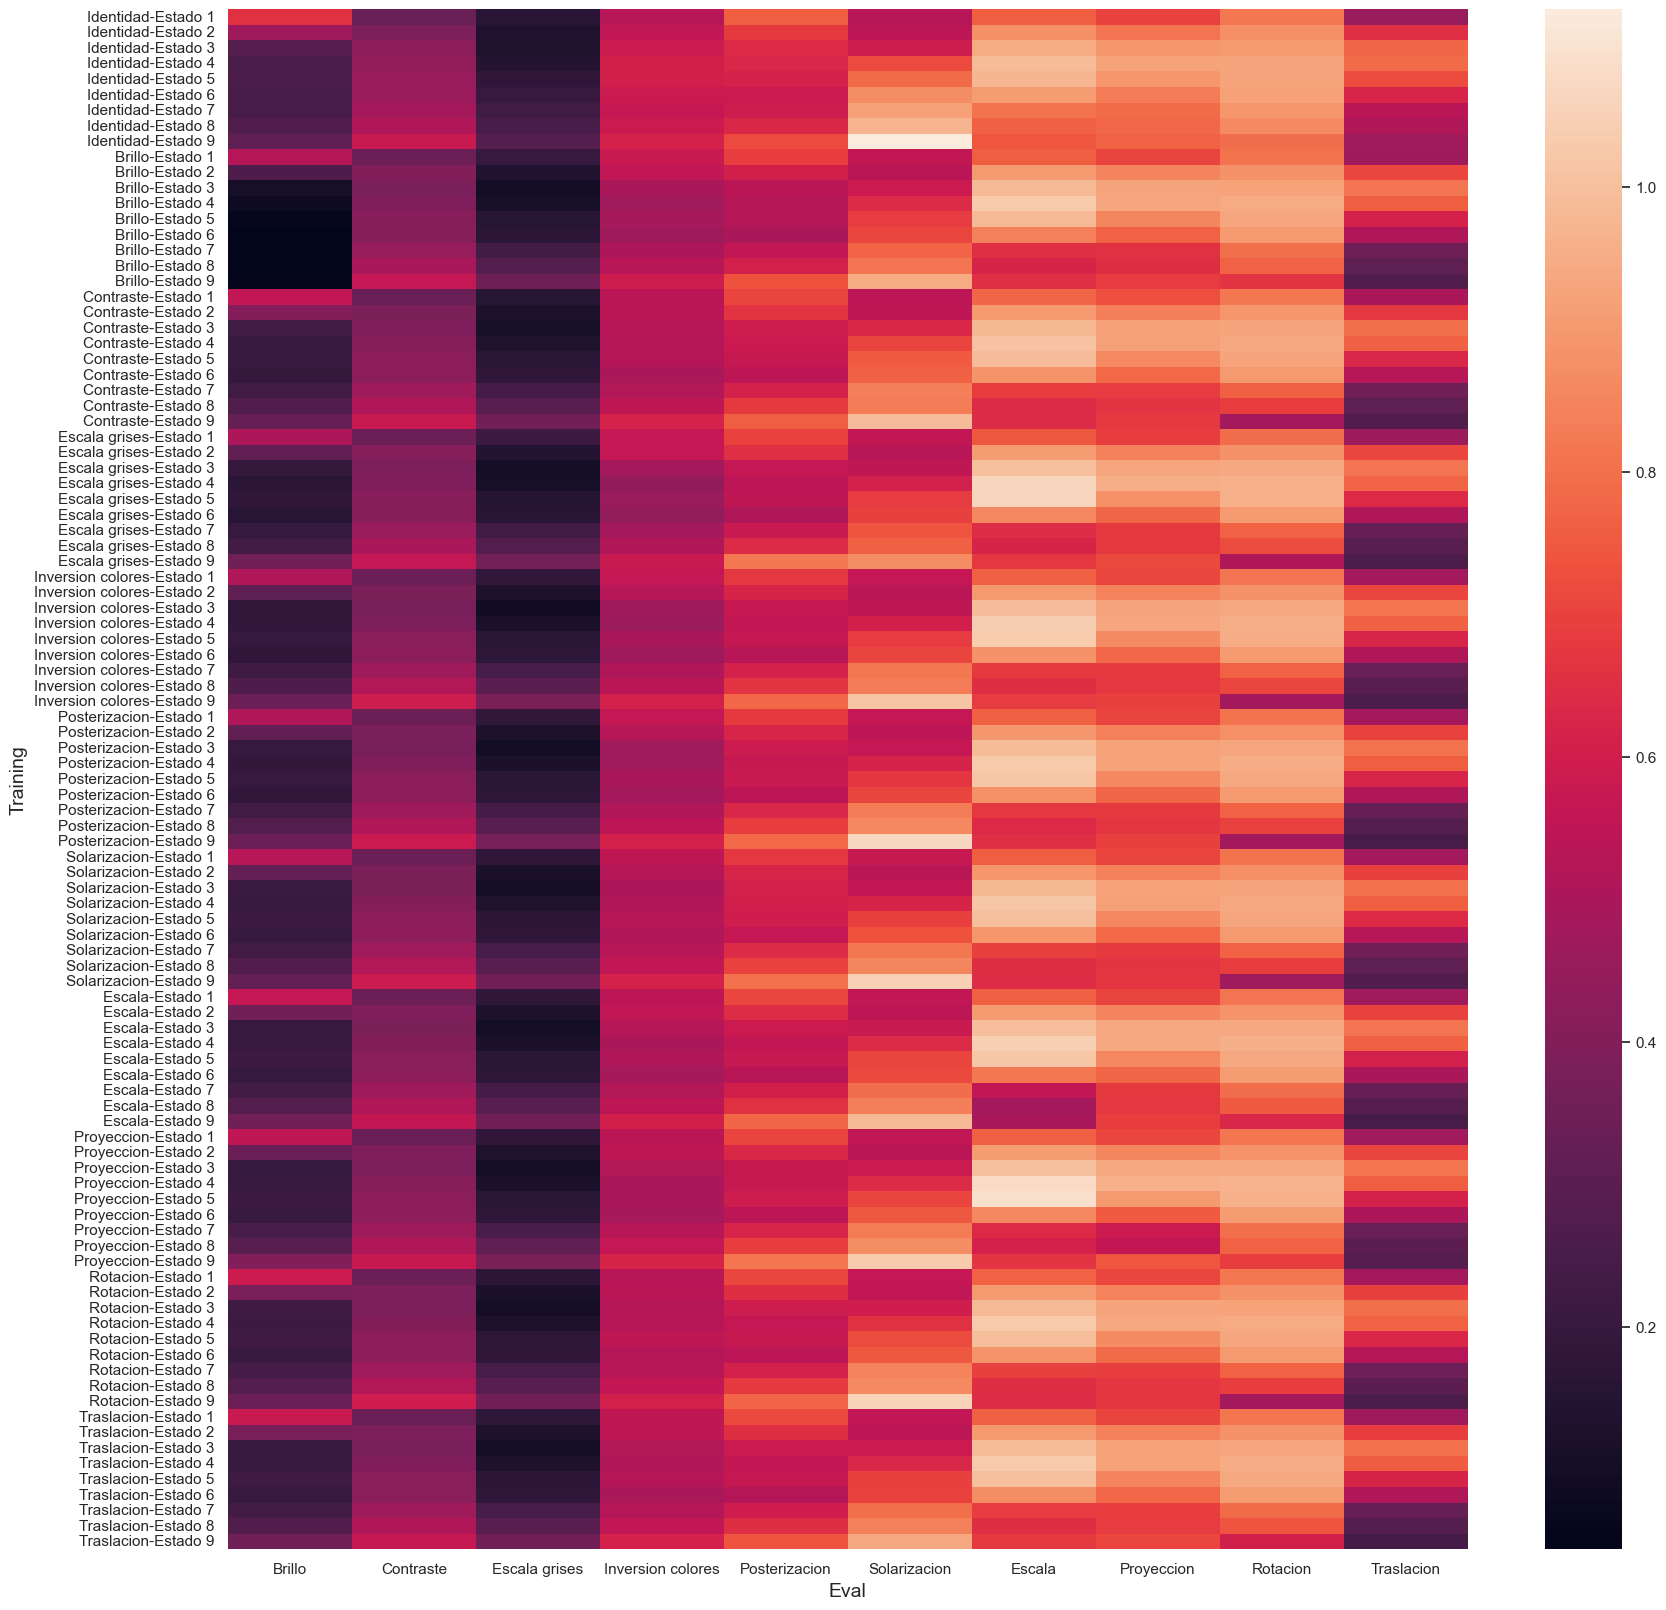

In [68]:
# Crear el mapa de colores
plt.figure(figsize=(20, 20))
sns.heatmap(df_pivot3, annot=False, cbar=True)
plt.xlabel('Eval', fontsize=14)
plt.ylabel('Training', fontsize=14)
#plt.title('Heatmap de promedio de Invarianza por Estado')
plt.savefig('fromscratch_heatmap_promedio_invarianza_estado_sinSE.png', dpi=300, bbox_inches='tight')  # Alta calidad para impresión

plt.show()


In [69]:
df_pivot4 = df_mean2.pivot_table(index=['Training'], columns='Eval', values='inv_avg', aggfunc='mean')
df_pivot4

Eval,Brillo,Contraste,Escala grises,Inversion colores,Posterizacion,Solarizacion,Escala,Proyeccion,Rotacion,Traslacion
Training,,,,,,,,,,
Identidad,0.334527,0.452445,0.190168,0.580898,0.648731,0.783370,0.862257,0.820966,0.878968,0.616111
Brillo,0.136363,0.427190,0.193957,0.522579,0.586348,0.694165,0.825162,0.780392,0.846929,0.532956
Contraste,0.291487,0.436229,0.195542,0.538746,0.634594,0.734723,0.834827,0.784871,0.814781,0.536124
Escala grises,0.257113,0.430942,0.194837,0.503495,0.618249,0.667710,0.841179,0.793367,0.826457,0.531261
Inversion colores,0.266600,0.434838,0.198227,0.516868,0.620739,0.700924,0.846671,0.790083,0.821142,0.533680
Posterizacion,0.272098,0.433350,0.196219,0.522284,0.631072,0.713088,0.837196,0.785100,0.817287,0.527306
Solarizacion,0.279061,0.439979,0.198787,0.538265,0.647102,0.715986,0.835721,0.782281,0.811859,0.537264
Escala,0.290200,0.432926,0.195322,0.533174,0.626664,0.706112,0.786252,0.790012,0.845946,0.524245
Proyeccion,0.295909,0.438370,0.202637,0.534990,0.638394,0.721811,0.845838,0.778154,0.858870,0.533400


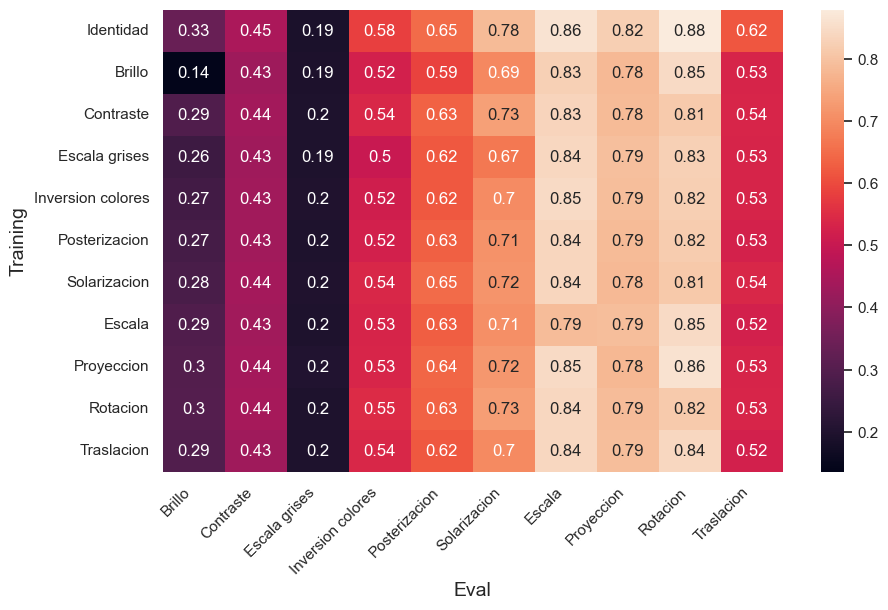

In [93]:
# Crear el mapa de colores
plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot4, annot=True, cbar=True)

#plt.title('Heatmap de promedio de Invarianza por Estado')
plt.xlabel('Eval', fontsize=14)
plt.ylabel('Training', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas en el eje X
plt.yticks(rotation=0)  # Mantener etiquetas del eje Y horizontales

#plt.title('Heatmap de promedio de Invarianza por Estado')
plt.savefig('fromscratch_heatmap_promedio_de_los_promedios_invarianza_por_estado_sinSE.png', dpi=300, bbox_inches='tight')  # Alta calidad para impresión

plt.show()

### Mismo analisis de la salida de cada bloque

In [71]:
# Función para extraer el sufijo numérico
def extract_numeric_suffix(layer):
    match = re.search(r'_(\d+)$', layer)
    return int(match.group(1)) if match else -1

# Crear una nueva columna con el sufijo numérico
df_complete['layer_num'] = df_complete['layer'].apply(extract_numeric_suffix)

# Ordenar el DataFrame por 'Training', 'Eval', 'Sequential' y 'layer_num'
df_sorted = df_complete.sort_values(by=['Training', 'Eval', 'Sequential', 'layer_num'], ascending=[True, True, True, False])

# Obtener la capa con el valor más grande en el sufijo dentro de cada grupo
df_max_layer = df_sorted.groupby(['Training', 'Eval', 'Sequential']).first().reset_index()

# Eliminar la columna auxiliar 'layer_num' si ya no es necesaria
df_max_layer = df_max_layer.drop(columns=['layer_num'])

# Mostrar el DataFrame con la capa de mayor valor en el sufijo por grupo
df_max_layer

,Training,Eval,Sequential,layer_name,inv_avg,1,2,3,4,layer
0,Identidad,Identidad,Estado 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Identidad,Identidad,Estado 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Identidad,Identidad,Estado 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Identidad,Identidad,Estado 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Identidad,Identidad,Estado 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1084,Traslacion,Traslacion,Estado 5,Sequential_4/MBConv_2/block/Conv2dNormActivati...,0.680547,MBConv_2,block,Conv2dNormActivation_3,BatchNorm2d_1,BatchNorm2d_103
1085,Traslacion,Traslacion,Estado 6,Sequential_5/MBConv_2/block/Conv2dNormActivati...,0.551523,MBConv_2,block,Conv2dNormActivation_3,BatchNorm2d_1,BatchNorm2d_142
1086,Traslacion,Traslacion,Estado 7,Sequential_6/MBConv_3/block/Conv2dNormActivati...,0.348007,MBConv_3,block,Conv2dNormActivation_3,BatchNorm2d_1,BatchNorm2d_194
1087,Traslacion,Traslacion,Estado 8,Sequential_7/MBConv_0/block/Conv2dNormActivati...,0.302341,MBConv_0,block,Conv2dNormActivation_3,BatchNorm2d_1,BatchNorm2d_207


In [72]:
df_max_layer = df_max_layer.loc[(df_max_layer.Eval != 'Identidad') ]

In [73]:
df_pivot5 = df_max_layer.pivot(index=['Training', 'Sequential'], columns=["Eval"], values="inv_avg")
df_pivot5

Eval                     Brillo  Contraste  Escala grises  Inversion colores  \
Training   Sequential                                                          
Identidad  Estado 1    0.662298   0.328400       0.155543           0.527348   
           Estado 2    0.361540   0.424267       0.139137           0.634735   
           Estado 3    0.273830   0.456611       0.138095           0.620104   
           Estado 4    0.271549   0.472387       0.165909           0.636904   
           Estado 5    0.281251   0.487144       0.202705           0.641912   
...                         ...        ...            ...                ...   
Traslacion Estado 5    0.238654   0.443110       0.185403           0.557721   
           Estado 6    0.219111   0.458173       0.201269           0.547647   
           Estado 7    0.273430   0.526718       0.297623           0.583544   
           Estado 8    0.348720   0.600294       0.386330           0.643555   
           Estado 9    0.504102   0.643788       0.407830           0.660372   

Eval                   Posterizacion  Solarizacion    Escala  Proyeccion  \
Training   Sequential                                                      
Identidad  Estado 1         0.762952      0.458330  0.751549    0.693279   
           Estado 2         0.684731      0.646527  0.941101    0.850960   
           Estado 3         0.677149      0.744457  1.017050    0.960992   
           Estado 4         0.658643      0.866094  1.035744    0.950161   
           Estado 5         0.637757      0.938114  1.006690    0.917551   
...                              ...           ...       ...         ...   
Traslacion Estado 5         0.590049      0.831134  1.065862    0.892732   
           Estado 6         0.566122      0.846727  0.899054    0.810120   
           Estado 7         0.653072      0.926671  0.710876    0.735692   
           Estado 8         0.750786      0.939448  0.702031    0.741498   
           Estado 9         0.861843      1.216315  0.851117    0.818735   

Eval                   Rotacion  Traslacion  
Training   Sequential                        
Identidad  Estado 1    0.809040    0.452171  
           Estado 2    0.914532    0.741155  
           Estado 3    0.957637    0.842273  
           Estado 4    0.962040    0.814542  
           Estado 5    0.963386    0.759001  
...                         ...         ...  
Traslacion Estado 5    0.983858    0.680547  
           Estado 6    0.936482    0.551523  
           Estado 7    0.827588    0.348007  
           Estado 8    0.756520    0.302341  
           Estado 9    0.495921    0.218968  

[99 rows x 10 columns]

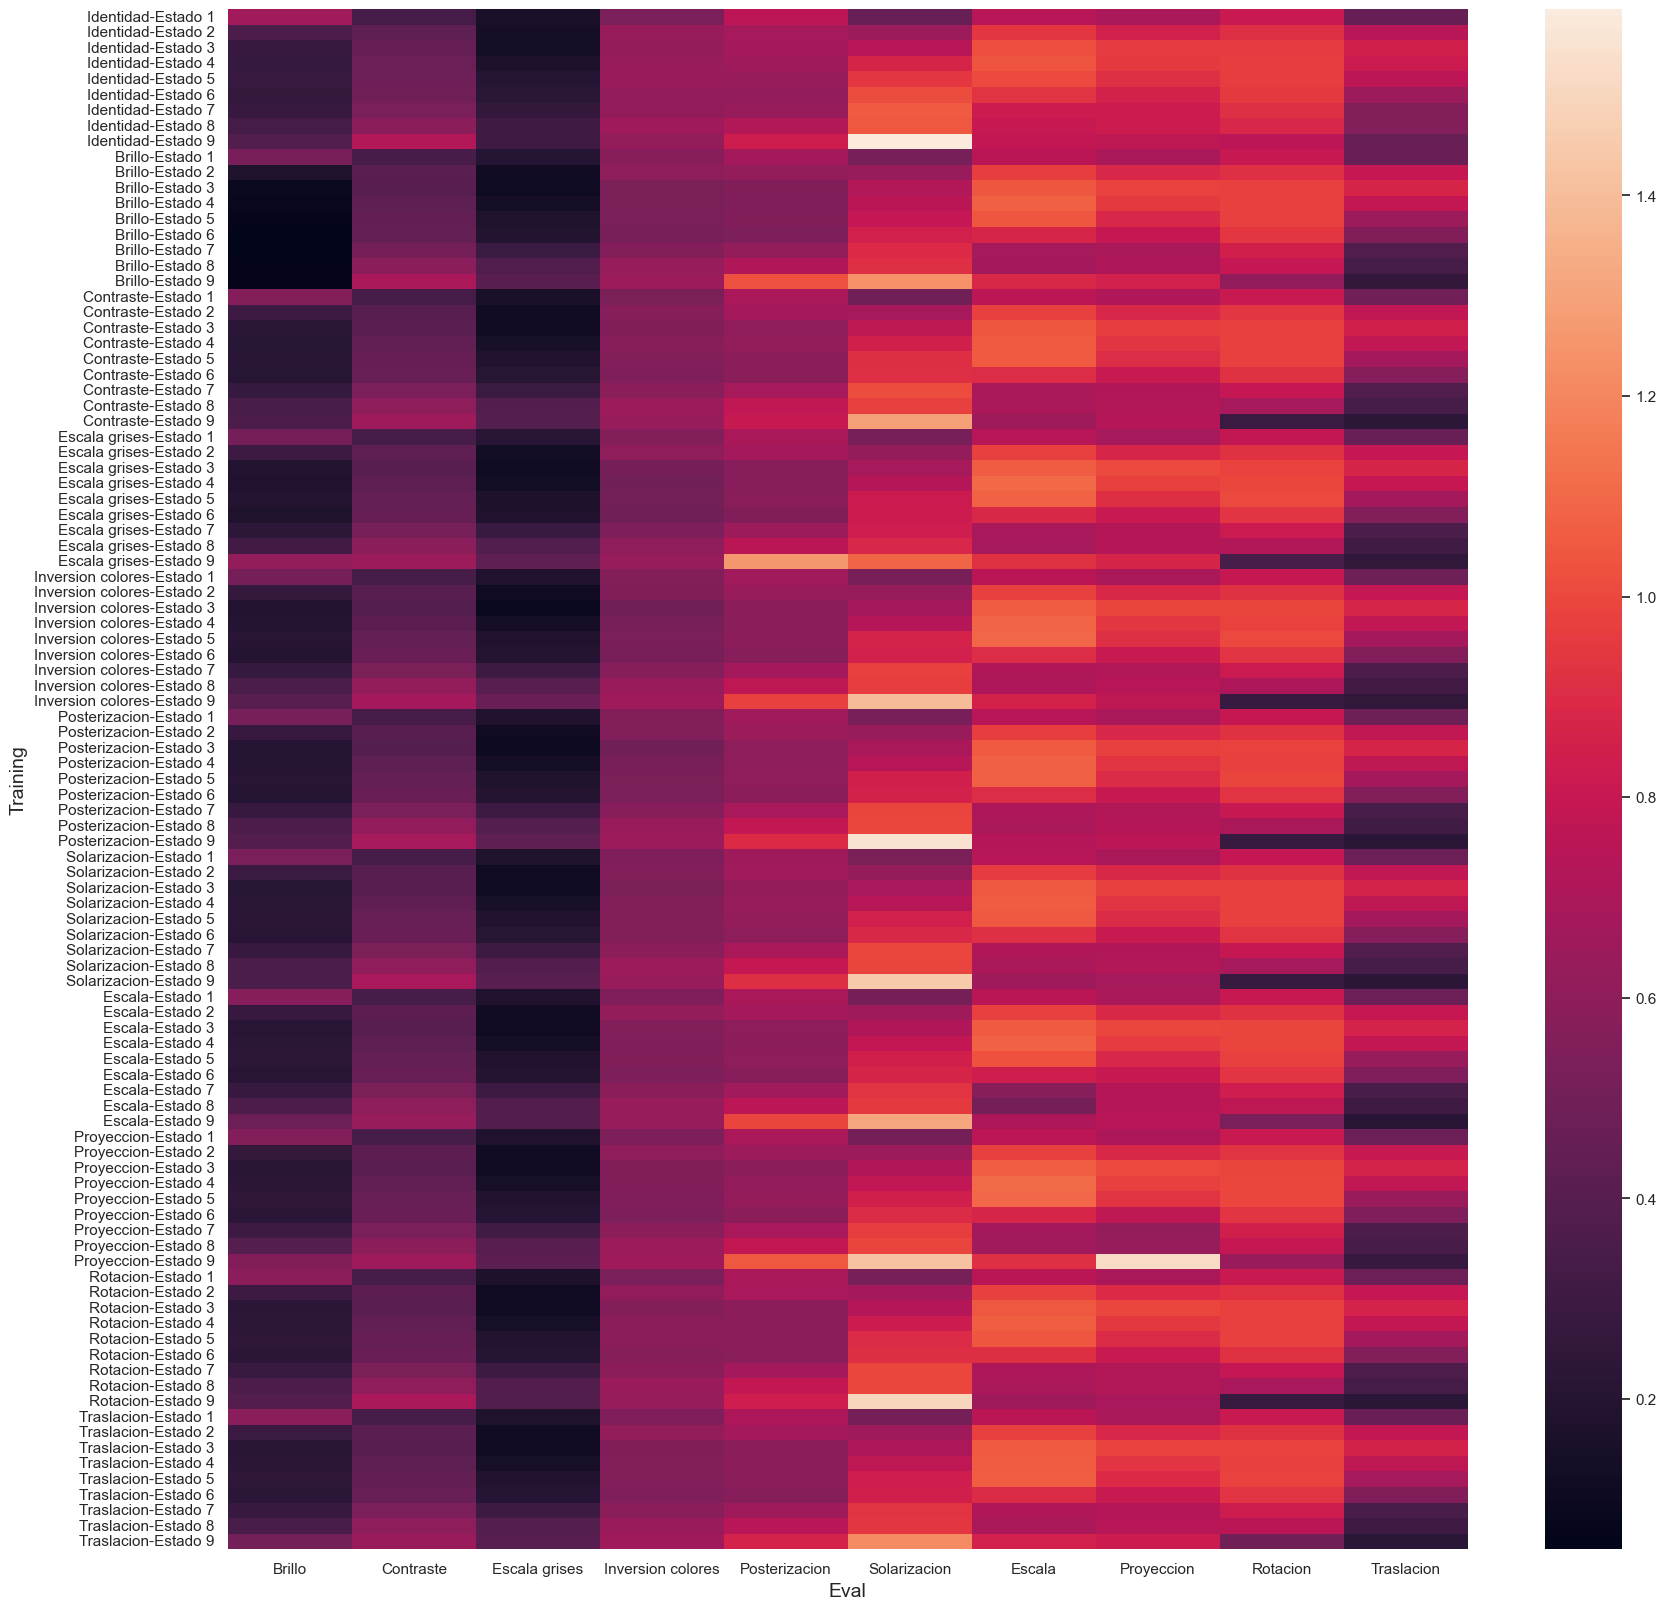

In [74]:
# Crear el mapa de colores
plt.figure(figsize=(20, 20))
sns.heatmap(df_pivot5, annot=False, cbar=True)
plt.xlabel('Eval', fontsize=14)
plt.ylabel('Training', fontsize=14)
#plt.title('Heatmap de promedio de Invarianza por Estado')
plt.savefig('fromscratch_heatmap_invarianza_salida_estado.png', dpi=300, bbox_inches='tight')  # Alta calidad para impresión

plt.show()

In [75]:
df_pivot6 = df_max_layer.pivot_table(index=['Training'], columns='Eval', values='inv_avg', aggfunc='mean')
df_pivot6

Eval,Brillo,Contraste,Escala grises,Inversion colores,Posterizacion,Solarizacion,Escala,Proyeccion,Rotacion,Traslacion
Training,,,,,,,,,,
Identidad,0.343812,0.499847,0.210014,0.617943,0.690991,0.928365,0.898930,0.849019,0.901186,0.648321
Brillo,0.128739,0.473814,0.220906,0.567968,0.647806,0.814237,0.887556,0.829003,0.869466,0.564065
Contraste,0.299486,0.476462,0.221083,0.577927,0.670213,0.875919,0.873657,0.820365,0.817216,0.564162
Escala grises,0.301760,0.472878,0.223496,0.549290,0.702930,0.777928,0.903396,0.842951,0.834066,0.563181
Inversion colores,0.289874,0.477054,0.229877,0.559121,0.673514,0.843896,0.904527,0.831522,0.825595,0.564938
Posterizacion,0.292708,0.476115,0.224386,0.562180,0.674139,0.870107,0.883534,0.824271,0.820741,0.556151
Solarizacion,0.295893,0.482117,0.224529,0.577241,0.689531,0.861485,0.872751,0.813086,0.813677,0.563465
Escala,0.315601,0.473253,0.221785,0.578545,0.683567,0.841590,0.835474,0.826553,0.860321,0.551306
Proyeccion,0.330133,0.479914,0.230956,0.580774,0.698680,0.863084,0.903761,0.892938,0.881102,0.564011


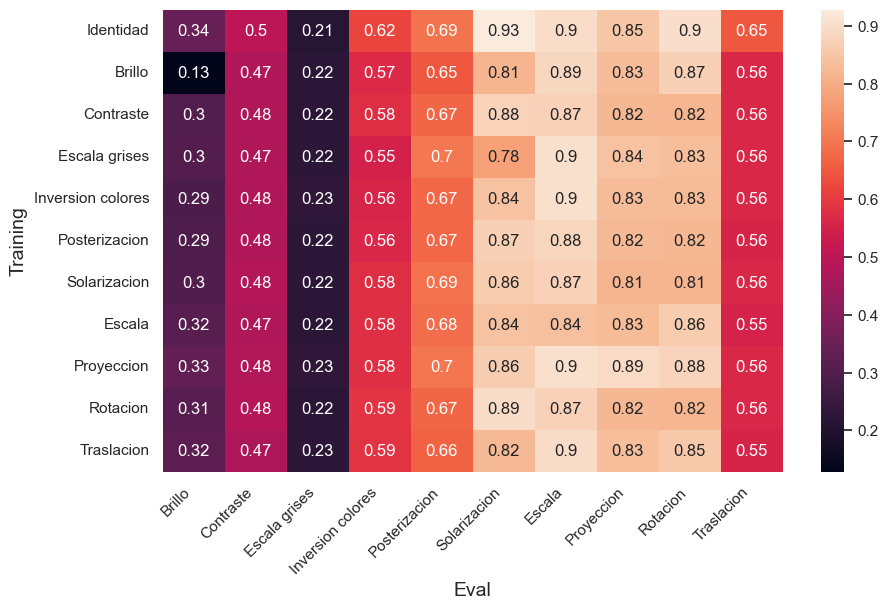

In [92]:
# Crear el mapa de colores
plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot6, annot=True, cbar=True)

#plt.title('Heatmap de promedio de Invarianza por Estado')
plt.xlabel('Eval', fontsize=14)
plt.ylabel('Training', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas en el eje X
plt.yticks(rotation=0)  # Mantener etiquetas del eje Y horizontales

#plt.title('Heatmap de promedio de Invarianza por Estado')
plt.savefig('fromscratch_heatmap_promedio_invarianza_salidas.png', dpi=300, bbox_inches='tight')  # Alta calidad para impresión

plt.show()

## Accuracy Training Set

In [82]:
df_acc = pd.read_csv('models/efficientnet_b0/weights_none/performance_metrics_final_training.csv')

In [83]:
df_acc

,Transformation_training,Accuracy_Train,Loss_Train,Precision_Train,Recall_Train,Transformation_eval,Unnamed: 0,epoch
0,proyeccion,0.518450,2.602824,0.571517,0.518450,rotacion,NaN,NaN
1,contraste,0.888520,0.407397,0.889951,0.888520,rotacion,NaN,NaN
2,contraste,0.838045,1.151487,0.840293,0.838045,traslacion,NaN,NaN
3,contraste,0.710903,4.567888,0.744191,0.710903,escala,NaN,NaN
4,contraste,0.600267,9.687851,0.664359,0.600267,proyeccion,NaN,NaN
...,...,...,...,...,...,...,...,...
105,posterizacion,0.590000,21.790000,0.700000,0.590000,contraste,104.0,104.0
106,posterizacion,0.610000,23.110000,0.700000,0.610000,escala_grises,105.0,105.0
107,posterizacion,0.570000,800.160000,0.660000,0.570000,solarizacion,106.0,106.0
108,posterizacion,0.550000,806.930000,0.650000,0.550000,posterizacion,107.0,107.0


In [89]:
df_acc.Transformation_training.value_counts()

Proyeccion           10
Contraste            10
Traslacion           10
Brillo               10
Escala               10
Inversion colores    10
Escala grises        10
Rotacion             10
Solarizacion         10
Identidad            10
Posterizacion        10
Name: Transformation_training, dtype: int64

In [86]:
df_acc.loc[df_acc.Transformation_training == 'without_transformation','Transformation_training'] = 'Identidad'

In [88]:
# Función para transformar los valores
def transformar_texto(texto):
    return texto.replace('_', ' ').capitalize()

# Aplicar la transformación a la columna
df_acc['Transformation_training'] = df_acc['Transformation_training'].apply(transformar_texto)
df_acc['Transformation_eval'] = df_acc['Transformation_eval'].apply(transformar_texto)

In [99]:
order_transformation = CategoricalDtype(
    ['Identidad','Brillo', 'Contraste', 'Escala grises','Inversion colores', 'Posterizacion','Solarizacion', 
     'Escala','Proyeccion', 'Rotacion', 'Traslacion'],
    ordered=True
)

# Convertir columnas al tipo categórico
df_acc['Transformation_training'] = df_acc['Transformation_training'].astype(order_transformation)
df_acc['Transformation_eval'] = df_acc['Transformation_eval'].astype(order_transformation)
df_acc.sort_values(by = ['Transformation_training','Transformation_eval'], ascending=[True, True],inplace=True)
df_acc

,Transformation_training,Accuracy_Train,Loss_Train,Precision_Train,Recall_Train,Transformation_eval,Unnamed: 0,epoch
94,Identidad,0.44,23.07,0.54,0.44,Brillo,93.0,93.0
95,Identidad,0.39,31.35,0.50,0.39,Contraste,94.0,94.0
96,Identidad,0.46,32.07,0.56,0.46,Escala grises,95.0,95.0
99,Identidad,0.40,966.88,0.53,0.40,Inversion colores,98.0,98.0
98,Identidad,0.43,959.15,0.55,0.43,Posterizacion,97.0,97.0
...,...,...,...,...,...,...,...,...
27,Traslacion,0.57,1001.22,0.67,0.57,Solarizacion,16.0,16.0
22,Traslacion,0.76,4.48,0.79,0.76,Escala,11.0,11.0
23,Traslacion,0.66,10.53,0.72,0.66,Proyeccion,12.0,12.0
20,Traslacion,0.67,1.52,0.70,0.67,Rotacion,9.0,9.0


In [97]:
df_acc.shape

(110, 8)

In [98]:
11*10

110

In [90]:
df_acc.head()

,Transformation_training,Accuracy_Train,Loss_Train,Precision_Train,Recall_Train,Transformation_eval,Unnamed: 0,epoch
0,Proyeccion,0.518450,2.602824,0.571517,0.518450,Rotacion,NaN,NaN
1,Contraste,0.888520,0.407397,0.889951,0.888520,Rotacion,NaN,NaN
2,Contraste,0.838045,1.151487,0.840293,0.838045,Traslacion,NaN,NaN
3,Contraste,0.710903,4.567888,0.744191,0.710903,Escala,NaN,NaN
4,Contraste,0.600267,9.687851,0.664359,0.600267,Proyeccion,NaN,NaN


In [96]:
df_acc.loc[df_acc.Transformation_training == 'Identidad']

,Transformation_training,Accuracy_Train,Loss_Train,Precision_Train,Recall_Train,Transformation_eval,Unnamed: 0,epoch
90,Identidad,0.14,7.71,0.18,0.14,Rotacion,89.0,89.0
91,Identidad,0.44,8.75,0.52,0.44,Traslacion,90.0,90.0
92,Identidad,0.44,13.43,0.52,0.44,Escala,91.0,91.0
93,Identidad,0.37,21.71,0.49,0.37,Proyeccion,92.0,92.0
94,Identidad,0.44,23.07,0.54,0.44,Brillo,93.0,93.0
95,Identidad,0.39,31.35,0.50,0.39,Contraste,94.0,94.0
96,Identidad,0.46,32.07,0.56,0.46,Escala grises,95.0,95.0
97,Identidad,0.43,953.73,0.55,0.43,Solarizacion,96.0,96.0
98,Identidad,0.43,959.15,0.55,0.43,Posterizacion,97.0,97.0
99,Identidad,0.40,966.88,0.53,0.40,Inversion colores,98.0,98.0


In [100]:
df_acc_pivot = df_acc.pivot(index=['Transformation_training'], columns=["Transformation_eval"], values="Accuracy_Train")

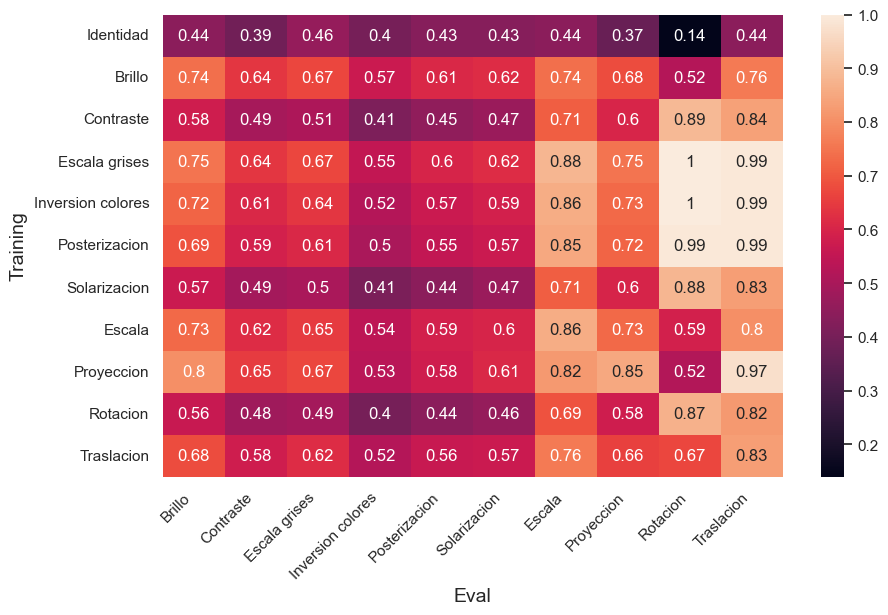

In [101]:
# Crear el mapa de colores
plt.figure(figsize=(10, 6))
sns.heatmap(df_acc_pivot, annot=True, cbar=True)

#plt.title('Heatmap de promedio de Invarianza por Estado')
plt.xlabel('Eval', fontsize=14)
plt.ylabel('Training', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas en el eje X
plt.yticks(rotation=0)  # Mantener etiquetas del eje Y horizontales

#plt.title('Heatmap de promedio de Invarianza por Estado')
plt.savefig('fromscratch_heatmap_acc_training_set.png', dpi=300, bbox_inches='tight')  # Alta calidad para impresión

plt.show()